In [1]:
"""A set of functions that can be used to compare Randomized Response to RAPPOR

This library contains functions that can generate random PMFs, draw samples from
a given PMF, enocde data using both RAPPOR and Randomized Response, and apply
various decoders for both RAPPOR and Randomized Response.
"""
#%matplotlib inline
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import timeit

def project_probability_simplex(p_estimate):
  """Projects a PMF estimate onto the probability simplex.

  Args:
    pmf_estimate: A PMF estimate.
  This functions implements Algorithm 1 in http://arxiv.org/abs/1309.1541
  """
  k = len(p_estimate)  # Infer the size of the alphabet.
  p_estimate_sorted = np.sort(p_estimate)
  p_estimate_sorted[:] = p_estimate_sorted[::-1]
  p_sorted_cumsum = np.cumsum(p_estimate_sorted)
  i = 1
  while i < k:
    if p_estimate_sorted[i] + (1.0 / (i + 1)) * (1 - p_sorted_cumsum[i]) < 0:
      break
    i += 1
  lmd = (1.0 / i) * (1 - p_sorted_cumsum[i - 1])
  return np.maximum(p_estimate + lmd, 0)


#clip and normalize
def probability_normalize(dist):
    dist = np.maximum(dist,0) #map it to be positive
    norm = np.sum(dist)
    dist = np.true_divide(dist,norm) #ensure the l_1 norm is one
    return dist

def decode_counts(counts, epsilon, n, k):
  """Estimates PMF under RAPPOR and Randomized Response using standard decoding.

  Args:
    counts: An array containing the number of times each element showed up.
    epsilon: The differential privacy level. If decode_counts is used for RAPPOR
      epsilon/2 is passed to the function.
    n: The number of samples (users).
    k: The size of the alphabet. If decode_counts is used for RAPPOR k = 2 is
      passed to the function.
  """
  p_estimate = (counts / float(n)) * (
      (math.exp(epsilon) + k - 1) /
      (math.exp(epsilon) - 1)) - 1.0 / (math.exp(epsilon) - 1)
  return p_estimate

def randomized_response_encoder(samples, epsilon, k):
  """Encodes the samples using Randomized Response.

  Args:
    samples: The samples to be encoded.
    epsilon: The differential privacy level.
    k: The size of the alphabet.
  """
  n = len(samples)
  q = math.exp(epsilon) / (math.exp(epsilon) + k - 1)
  # Start by setting private_samples = samples.
  private_samples_rr = np.copy(samples)
  # Determine which samples need to be noised ("flipped").
  flip = np.random.random_sample(n) > q
  flip_samples = samples[flip]
  # Select new samples uniformly at random to replace the original ones.
  rand_samples = np.random.randint(0, k - 1, len(flip_samples))
  # Shift the samples if needed to avoid sampling the orginal samples.
  rand_samples[rand_samples >= flip_samples] += 1
  # Replace the original samples by the randomly selected ones.
  private_samples_rr[flip] = rand_samples
  return private_samples_rr


def rappor_encoder(samples, epsilon, k):
  """Encodes the samples using RAPPOR.

  Args:
    samples: A 1-d numpy array of length n, where each entry is an integer in
      [0,k). These are the input values to be RAPPOR-encoded.
    epsilon: The differential privacy level.
    k: The size of the alphabet.
  """
  n = len(samples)
  users = range(n)
  q = math.exp(epsilon / 2.0) / (math.exp(epsilon / 2.0) + 1)
  # One-hot encode the input integers.
  private_samples_rappor = np.zeros((n, k))
  private_samples_rappor[users, samples] = 1
  # Flip the RAPPOR encoded bits with probability p = 1 - q.
  flip = np.random.random_sample((n, k))
  return np.logical_xor(private_samples_rappor, flip > q)


def rappor_encoder_light(samples, epsilon, k):
  #return to count vector of rappor responce, which is less memory intensive
  #also return the cumulated time for adding rappor vectors, which should also be considered as decoding time.
  n = len(samples)
  users = range(n)
  q = math.exp(epsilon / 2.0) / (math.exp(epsilon / 2.0) + 1)
  time = 0
  counts = np.zeros(k)
  # One-hot encode the input integers.
  for i in range(n):
      private_samples_rappor = np.zeros(k)
      private_samples_rappor[samples[i]] = 1
      # Flip the RAPPOR encoded bits with probability p = 1 - q.
      flip = np.random.random_sample(k)
      private_samples_rappor = np.logical_xor(private_samples_rappor, flip > q) 
      start_time = timeit.default_timer() #record adding time
      counts = counts + private_samples_rappor # add rappor responce vector
      time = time + timeit.default_timer() - start_time      
  return counts,time

def rappor_encoder_compress(samples, epsilon, k):
  #encode rappor responces into locations of one, which saves communcation budget when eps is large
  n = len(samples)
  users = range(n)
  q = math.exp(epsilon / 2.0) / (math.exp(epsilon / 2.0) + 1)
  out = [0]*n
  # One-hot encode the input integers.
  for i in range(n):
      private_samples_rappor = np.zeros(k)
      private_samples_rappor[samples[i]] = 1
      # Flip the RAPPOR encoded bits with probability p = 1 - q.
      flip = np.random.random_sample(k)
      private_samples_rappor = np.logical_xor(private_samples_rappor, flip > q) 
      out[i] = np.where(private_samples_rappor)[0] # get the locations of ones
  out_list = np.concatenate(out)
  return out_list


def rappor_decoder(counts_rappor, epsilon, n, normalization = 0):
  """Decodes RAPPOR encoded samples using a standard decoder.
  
  Args:
    counts_rappor: A 1-d numpy array containing the counts under RAPPOR.
    epsilon: The differential privacy level.
    n: The number of samples.
  """
  #normalization options: 0: clip and normalize(default)
  #                       1: simplex projection
  #                       else: no nomalization
  # Estimate the PMF using the count vector
  p_rappor = decode_counts(counts_rappor, epsilon / 2.0, n, 2)
    
  if normalization == 0: 
      p_rappor = probability_normalize(p_rappor) #clip and normalize
  if normalization == 1:
      p_rappor = project_probability_simplex(p_rappor) #simplex projection
            

  return p_rappor


def rr_decoder(counts_rr, epsilon, n, normalization = 0):
  """Decodes RR encoded samples using a normalized standard decoder.

  Args:
    counts_rr: A 1-d numpy array containing the counts under RR.
    epsilon: The differential privacy level.
    n: The number of samples.
  """
  #normalization options: 0: clip and normalize(default)
  #                       1: simplex projection
  #                       else: no nomalization
  # Estimate the PMF using the count vector

  k = len(counts_rr)  # Infer the size of the alphabet.
  # Estimate the PMF using the count vector.
  p_rr = decode_counts(counts_rr, epsilon, n, k)
  # Check if truncation and renormalization is required.
  
  if normalization == 0: 
      p_rr = probability_normalize(p_rr) #clip and normalize
  if normalization == 1:
      p_rr = project_probability_simplex(p_rr) #simplex projection

  return p_rr

l1 distance:  0.34017615767076337
prob_sum:  0.9999999999999998
l1 distance:  0.215056204671582
prob_sum:  0.999999999999999


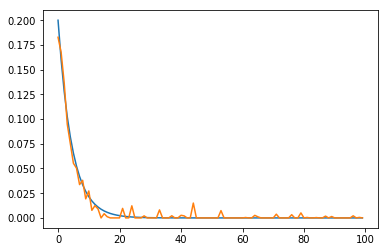

In [3]:
#Testing Script
if __name__ == "__main__":
    k = 100 #absz
    n = 1000000
    elements = range(0,k) #ab
    lbd = 0.8 #parameter for geometric dist
    eps = 1 # privacy_para
    prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist
    #prob = [1/float(k)] * k
    in_list = np.random.choice(elements, n, p=prob) #input symbols
    sample = randomized_response_encoder(in_list, eps, k)
    (outp, temp) = np.histogram(sample,range(k+1))
    #print outp
    prob_est = rr_decoder(outp,eps,n) # estimate the original underlying distribution
    print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
    print ("prob_sum: ", str(sum(prob_est)))
    prob_est = rr_decoder(outp,eps,n,1) # estimate the original underlying distribution
    plt.plot(elements,prob)
    plt.plot(elements,prob_est)
    print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
    print ("prob_sum: ", str(sum(prob_est)))

l1 distance:  1.043060512687704
prob_sum:  1.0000000000000002
l1 distance:  0.24698932484652525
prob_sum:  0.9999999999999991


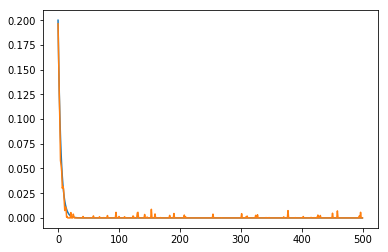

In [5]:
#Testing Script
if __name__ == "__main__":
    #sample = rappor_encoder(in_list, eps, k)
    #outp = np.sum(sample, axis=0)
    out_list = rappor_encoder_compress(in_list, eps, k)
    outp,temp = np.histogram(out_list,range(k+1))
    prob_est = rappor_decoder(outp,eps,n) # estimate the original underlying distribution
    print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
    print ("prob_sum: ", str(sum(prob_est)))
    prob_est = rappor_decoder(outp,eps,n,1)
    plt.plot(elements,prob)
    plt.plot(elements,prob_est)
    #plt.plot(prob_est)
    print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
    print ("prob_sum: ", str(sum(prob_est)))